<a href="https://colab.research.google.com/github/vkthakur90/Indian-Music/blob/main/Western_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import google.colab.files as gcf

In [3]:
TEMPO = 60 #beats_per_minute

BASE_FREQ = 440 * 2 ** (-9/12) #Hertz
PI = np.pi

In [4]:
melody = [
    ('quaver', 'E'),
    ('quaver', 'E'),
    ('quaver', 'E'),
    ('quaver', 'B'),
    ('quaver', 'A'),
    ('quaver', 'B'),
    ('crotchet', 'G'),
    ('crotchet', 'A'),
    ('quaver', 'CH'),
    ('semi_breave', 'B'),
    ('minim', 'E'),
    ('quaver', 'B'),
    ('quaver', 'A'),
    ('quaver', 'B'),
    ('crotchet', 'G'),
    ('crotchet', 'A'),
    ('quaver', 'G'),
    ('semi_breave', 'FS'),
    ('quaver', 'E'),
    ('quaver', 'E'),
    ('quaver', 'E'),
    ('quaver', 'B'),
    ('quaver', 'A'),
    ('quaver', 'B'),
    ('crotchet', 'G'),
    ('crotchet', 'A'),
    ('quaver', 'DH'),
    ('quaver', 'DH'),
    ('quaver', 'EH'),
    ('quaver', 'DH'),
    ('quaver', 'B'),
    ('quaver', 'E'),
    ('quaver', 'E'),
    ('quaver', 'E'),
    ('quaver', 'B'),
    ('quaver', 'A'),
    ('quaver', 'B'),
    ('crotchet', 'G'),
    ('crotchet', 'A'),
    ('quaver', 'CH'),
    ('semi_breave', 'B'),
    ('minim', 'E'),
    ('quaver', 'B'),
    ('quaver', 'A'),
    ('quaver', 'B'),
    ('crotchet', 'G'),
    ('crotchet', 'A'),
    ('quaver', 'G'),
    ('semi_breave', 'FS')
]

In [5]:
octaves_df = pd.DataFrame({
    'notes' : ['C', 'CS', 'D', 'DS', 'E', 'F', 'FS', 'G', 'GS', 'A', 'AS', 'B'],
    'cents' : 100 * np.arange(12)
})

In [6]:
octaves_df.eval('freq = @BASE_FREQ * 2 ** (cents/1200)', inplace = True)

In [7]:
notes_df = pd.DataFrame({'n': np.arange(44100 * 4)})

notes_df.eval('t = n/44100', inplace = True)
notes_df.eval('beats = (@TEMPO * t / 60)', inplace = True)

notes_df.eval('N = floor(4 * beats) + 1', inplace = True)
notes_df.eval('REST = 0', inplace = True)
notes_df.eval('amp = (beats) * exp(-0.5 * (beats)**2)', inplace = True)

minim_notes_df = notes_df.copy()
minim_notes_df.eval('amp =  (2 * beats) * exp(-0.5 * (2 * beats)**2)', inplace = True)
minim_notes_df = minim_notes_df.query('N <= 8')

crotchet_notes_df = notes_df.copy()
crotchet_notes_df.eval('amp =  (4 * beats) * exp(-0.5 * (4 * beats)**2)', inplace = True)
crotchet_notes_df = crotchet_notes_df.query('N <= 4')

quaver_notes_df = notes_df.copy()
quaver_notes_df.eval('amp =  (8 * beats) * exp(-0.5 * (8 * beats)**2)', inplace = True)
quaver_notes_df = quaver_notes_df.query('N <= 2')

semi_quaver_notes_df = notes_df.copy()
semi_quaver_notes_df.eval('amp =  (16 * beats) * exp(-0.5 * (16 * beats)**2)', inplace = True)
semi_quaver_notes_df = semi_quaver_notes_df.query('N <= 1')

for beat_df in [notes_df, minim_notes_df, crotchet_notes_df, quaver_notes_df, semi_quaver_notes_df]:
    for freq, notes in octaves_df[['freq', 'notes']].values:
        beat_df.eval(f'{notes}L = amp * sin(0.5 * 2 * @PI * {freq} * t)', inplace = True)

    for freq, notes in octaves_df[['freq', 'notes']].values:
        beat_df.eval(f'{notes} = amp * sin(2 * @PI * {freq} * t)', inplace = True)

    for freq, notes in octaves_df[['freq', 'notes']].values:
        beat_df.eval(f'{notes}H = amp * sin(2 * 2 * @PI * {freq} * t)', inplace = True)

    beat_df.drop(['t', 'n', 'N', 'amp'], axis = 1, inplace = True)

In [8]:
notes = {
    'semi_breave' : notes_df,
    'minim' : minim_notes_df,
    'crotchet' : crotchet_notes_df,
    'quaver' : quaver_notes_df,
    'semi_quaver' : semi_quaver_notes_df
}

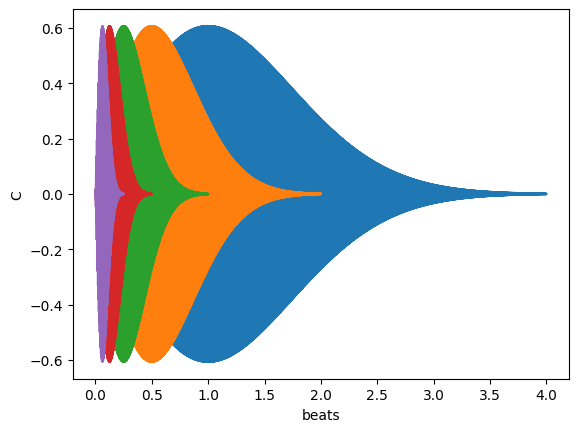

In [9]:
for key in notes.keys():
    sns.lineplot(x = 'beats', y = 'C', data = notes[key])

In [10]:
track_arr = np.concatenate([notes[beat][note].values for beat, note in melody])

track_norm = (track_arr - np.min(track_arr))/(np.max(track_arr) - np.min(track_arr))

track_quant = np.floor((2**16 - 1) * track_norm + 0.5)

track_byte = np.uint16(track_quant)

In [11]:
!rm -f music.raw music.mp3 music.mp4

In [12]:
with open('music.raw', 'wb') as wf:
    wf.write(bytearray(track_byte))

In [13]:
!ffmpeg -f u16le -ar 44100 -ac 1 -i music.raw music.mp3

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [14]:
!ffmpeg -i music.mp3 -filter_complex "[0:a]showcqt=s=1920x1080[v]" -map '[v]' -map '0:a' -c:a copy   music.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [15]:
gcf.download('music.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>